In [2]:
#Load the correct packages
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch import cuda
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split
from time import time
from tqdm.auto import tqdm
from sklearn.metrics import roc_curve, auc

First we define our U-net from the following classes DoubleConv, Downsample, Upsample and UNet. The DoubleConv corresponds to the blue arrows from the UNet figure, Downsample the red arrows and upsample the green arrows. The grey arrows are incorporated into the forward pass in the UNet class. 

In [3]:
class DoubleConv(nn.Module):
    # This is a class that defines a double convolutional layer,
    # which in the U-net structure corresponds to the blue arrows.
    def __init__(self, in_channels, out_channels, dropout_prob=0.2):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Dropout2d(p = dropout_prob),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.is_residual = in_channels == out_channels
    def forward(self, x):
        if self.is_residual:
            return x + self.conv_op(x)
        else:
            return self.conv_op(x)
    
class DownSample(nn.Module):
    # This is a class that defines a downsampling layer,
    # which in the figure corresponds to the red arrows.
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p
    
class UpSample(nn.Module):
    # This is a class that defines an upsampling layer,
    # which in the U-net figure corresponds to the green arrows.
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes,dropout_prob=0.2):
        super().__init__()
        self.sigmoid = nn.Sigmoid()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottleneck = nn.Sequential(
            DoubleConv(512, 1024, dropout_prob=dropout_prob),
            nn.Dropout2d(p=dropout_prob)  # Additional bottleneck dropout
        )
        
        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        #in the forward pass of the U-net save the hidden states as p1, p2, p3, p4,
        #these will be concatenated in the upsample layers corresponding to the grey arrows. 
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottleneck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)
        out = self.out(up_4)
        
        return self.sigmoid(out)

class CellDataset(Dataset):
    # This is a class that defines a dataset for our data.
    # It loads the preprossed data and returns the images and masks.
    def __init__(self, root_path, test=False):
        self.root_path = root_path
        if test:
            self.data = sorted([root_path+i for i in os.listdir(root_path)])
        else:
            self.data = sorted([root_path+i for i in os.listdir(root_path)])

    def __getitem__(self, index):
        data = np.load(self.data[index])
        img = data[:-1,:,:]
        mask = data[-1,:,:]
        
        return torch.tensor(img) / 255, torch.tensor(mask).unsqueeze(0)
    
    def __len__(self):
        return len(self.data)

# This function is used to move all the loaded data to the device that we trai on. 
def get_some_images(dataloader, device, n=1):
    """ Load n images from dataloader to device
    
        Returns a list of the images
    """
    Xs, ys = [], []
    i = 1
    for X, y in dataloader:
        X_temp = X.float().to(device)
        y_temp = y.float().to(device)
        Xs.append(X_temp)
        ys.append(y_temp)
        
        i += 1
        if i > n:
            break
    return Xs, ys


In [5]:
# Selecting the device to train on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

## Insert path to preprocessed image data, ending with /
DATA_PATH = r"C:\DATA\_KurserUNI\Deep Learning\Final Project\brightfield\training_data_64_bin/"

BATCH_SIZE = 64
#Setting of the data loader
train_dataset = CellDataset(DATA_PATH) #(well_50)
generator = torch.Generator().manual_seed(42)
#splitting into training and validation
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
t0 = time()
num_images = len(os.listdir(DATA_PATH))

#Using the data loader to move all the data onto the GPU (if available)
X, y = get_some_images(train_dataloader, device, num_images)
X_val, y_val = get_some_images(val_dataloader, device, num_images)
num_training_images = sum(X[i].shape[0] for i in range(len(X)))
num_validation_images = sum(X_val[i].shape[0] for i in range(len(X_val)))
print(f"Loaded batches of size {BATCH_SIZE} in {time() - t0:.2f}s:")
print(f" {len(X):2d} batches for training   ({num_training_images:4d} images),")
print(f" {len(X_val):2d} batches for validation ({num_validation_images:4d} images),")
print(f"for at total of {num_training_images + num_validation_images} images.\n")

print(f"Shape: {X[0].shape}")


Device: cuda
Loaded batches of size 64 in 1.90s:
 14 batches for training   ( 865 images),
  4 batches for validation ( 216 images),
for at total of 1081 images.

Shape: torch.Size([64, 11, 64, 64])


Initializing the model, with learning rate, structure, optimizer and loss function.

In [116]:
# Initialize model
model = UNet(11, 1, dropout_prob=0.40)
# model = torch.load('Unet_models/model_pre.pth')
# model.load_state_dict(torch.load('Unet_models/model_pre.pth'))
model = model.to(device)
# loss_fn = nn.BCEWithLogitsLoss()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)
#initialize losses
lost_cum = []
eva_cum = []

In the following section we are training the model. However since we are working with confidential data, we have pretrained a model that will be loaded later in this notebook. We just incluce the training procedure for completeness. The loading model is training exactly as shown below:

In [119]:
# Train the model
epochs = 30
t0 = time()
for epoch in (progress_bar := tqdm(range(epochs))):
    # Train on images
    loss_temp = 0
    #Each loop is one epoch. 
    model.train()
    for i in range(len(X)):
        out_test = model(X[i])
        loss = loss_fn(out_test, y[i])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_temp += loss.item()
    
    lost_cum.append(loss_temp/i)

    # Evaluate on validation set
    eva_temp = 0
    model.eval()
    for i in range(len(X_val)):
        out_test = model(X_val[i])
        loss = loss_fn(out_test, y_val[i])
        eva_temp += loss.item()
    
    eva_cum.append(eva_temp/i)
    # setting a postfix with both lost cum and eva cum
    progress_bar.set_postfix({"train_loss":lost_cum[-1], "val_loss":eva_cum[-1]})

    if not epoch % 10:
        print(f'oi oi oi only {epochs-epoch} to go! weeeee')
        last_10 = time() - t0
        t0 = time()
        
        if not epoch == 100:
            eta = last_10 / 10 * (epochs - epoch)
            print(f" Estimated remaining time: {eta:.2f}s")
    


  0%|          | 0/30 [00:00<?, ?it/s]

oi oi oi only 30 to go! weeeee
 Estimated remaining time: 28.35s
oi oi oi only 20 to go! weeeee
 Estimated remaining time: 188.83s
oi oi oi only 10 to go! weeeee
 Estimated remaining time: 94.62s


Plotting the validation and training loss:

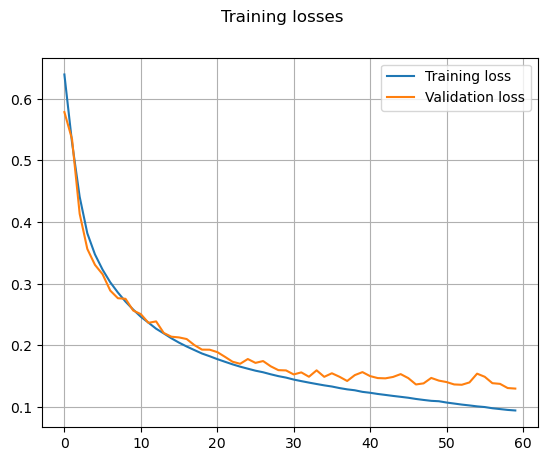

In [120]:
fig, ax = plt.subplots()
plt.suptitle('Training losses')
ax.plot(lost_cum, label='Training loss')
ax.plot(eva_cum, label='Validation loss')
ax.legend()
plt.grid(True)
plt.show()


In [121]:
#saving the model
torch.save(model.state_dict(), 'Unet_models/model_final_modified.pth')

Showing some sample model predictions on test data that was not seen in training:

In [ ]:
# Selecting the device to train on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

#Loading the model
model = UNet(11, 1)
model.load_state_dict(torch.load('model_final.pth'))
# model.load_state_dict(torch.load('model_final.pth', map_location=torch.device('cpu')))
model = model.to(device)
model.eval()


Device: cpu


UNet(
  (sigmoid): Sigmoid()
  (down_convolution_1): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(11, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout2d(p=0.2, inplace=False)
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_convolution_2): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout2d(p=0.2,

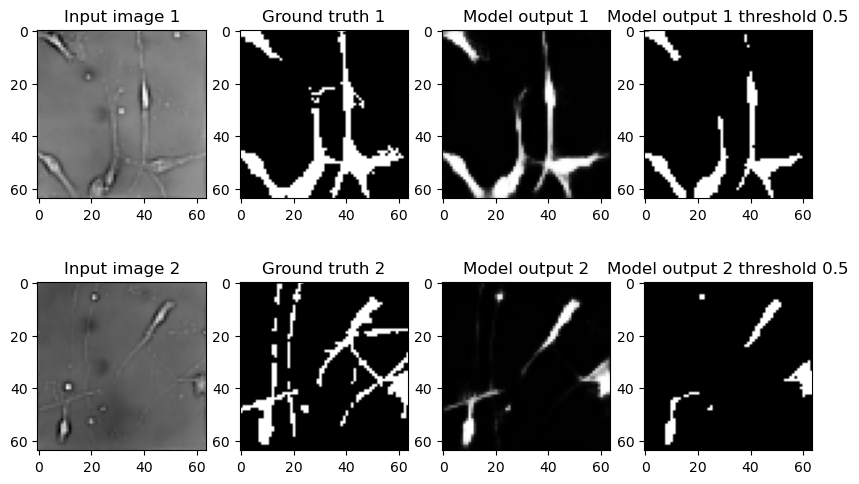

In [10]:
# Test on image we did not train on
test_image_1 = np.load('Test_images/well1_s01.npy')
img_1 = torch.tensor(test_image_1[:-1,:,:]/255).unsqueeze(0).float().to(device)
mask_1 = torch.tensor((test_image_1[-1,:,:]>0.5)*1).unsqueeze(0).float().to(device)

test_image_2 = np.load('Test_images/well1_s02.npy')
img_2 = torch.tensor(test_image_2[:-1,:,:]/255).unsqueeze(0).float().to(device)
mask_2 = torch.tensor((test_image_2[-1,:,:]>0.5)*1).unsqueeze(0).float().to(device)

model_out_1 = model(img_1).detach().cpu().numpy()
model_out_2 = model(img_2).detach().cpu().numpy()
fig,ax = plt.subplots(2,4, figsize=(10,6))
ax[0,0].imshow(img_1[0,0].cpu().numpy().squeeze(), cmap='gray')
ax[0,0].set_title('Input image 1')
ax[0,1].imshow(mask_1.cpu().numpy().squeeze(), cmap='gray')
ax[0,1].set_title('Ground truth 1')
ax[0,2].imshow(model_out_1.squeeze(), cmap='gray')
ax[0,3].set_title('Model output 1 threshold 0.5')
ax[0,3].imshow(model_out_1.squeeze()>0.5, cmap='gray')
ax[0,2].set_title('Model output 1')
ax[1,0].imshow(img_2[0,0].cpu().numpy().squeeze(), cmap='gray')
ax[1,0].set_title('Input image 2')
ax[1,1].imshow(mask_2.cpu().numpy().squeeze(), cmap='gray')
ax[1,1].set_title('Ground truth 2')
ax[1,2].imshow(model_out_2.squeeze(), cmap='gray')
ax[1,3].set_title('Model output 2 threshold 0.5')
ax[1,3].imshow(model_out_2.squeeze()>0.5, cmap='gray')
ax[1,2].set_title('Model output 2')
plt.show()

Following code demonstrate how we compute model metrics to meassure how well the model performs. We have implemented the following functions to do this: 


In [11]:
def confusion_image(truth, prediction):
    """ Returns images (True Positive, True Negative, False Positive, False Negative)
    """
    truth = truth > 0.5
    prediction = prediction > 0.5
    tp_im = np.logical_and(truth, prediction)
    tn_im = np.logical_and(np.logical_not(truth), np.logical_not(prediction))
    fp_im = np.logical_and(np.logical_not(truth), prediction)
    fn_im = np.logical_and(truth, np.logical_not(prediction))
    
    return tp_im, tn_im, fp_im, fn_im

def confusion(truth, prediction):
    """ Returns numbers (True Positive, True Negative, False Positive, False Negative)
    """
    tp, tn, fp, fn = confusion_image(truth, prediction)
    
    return np.sum(tp), np.sum(tn), np.sum(fp), np.sum(fn)

def iou(truth, prediction):
    """ Intersection over Union
    """
    tp, tn, fp, fn = confusion(truth, prediction)
    
    return tp / (tp + fp + fn)

def dsc(truth, prediction):
    """ Dice Similarity Coefficient, equivalent to bfscore
    """
    tp, tn, fp, fn = confusion(truth, prediction)
    
    return 2 * tp / (2 * tp + fp + fn)

def bfscore(truth, prediction):
    """ Boundary F1 score - equivalent to dsc
    """
    tp, tn, fp, fn = confusion(truth, prediction)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    
    return 2 * precision * recall / (precision + recall)

def visualize(model, X, y, m="Mean", debug=False):
    """ Visualizes validation metrics for the model:
    - IoU
    - DSC
    - ROC curve (AUC)
    
    Input:
    -
    - model: The model to evaluate
    - X: List of batches of images
    - y: List of batches of masks
    
    Output:
    - List of best and worst performing images by IoU and DSC
    """
    if debug:
        print(f"{len(X)} batches of {len(X[0])} images each (last has {len(X[-1])} images)", end=", ")
        print(f"for at total of {sum(X[i].shape[0] for i in range(len(X)))} images.")
    
    iou_list = []
    dsc_list = []
    auc_pred = []
    auc_true = []
    
    # Keeping track of "best and worst performing" images
    iou_best_image = None
    iou_worst_image = None
    iou_best = -np.inf
    iou_worst = np.inf
    dsc_best_image = None
    dsc_worst_image = None
    dsc_best = -np.inf
    dsc_worst = np.inf
    
    for X_batch, y_batch in zip(X, y):  # Going through each batch
        model_out = model(X_batch).detach().cpu().numpy()
        y_batch = y_batch.detach().cpu().numpy()
        
        for image, pred, true in zip(X_batch, model_out, y_batch):  # Calculating metrics for each image in the batch
            # Intersection over Union
            iou_score = iou(true, pred)
            iou_list.append(iou_score)
            if iou_score > iou_best:
                iou_best = iou_score
                iou_best_image = (image, pred, true, iou_best)
            if iou_score < iou_worst:
                iou_worst = iou_score
                iou_worst_image = (image, pred, true, iou_worst)
            
            # Dice Similarity Coefficient
            dsc_score = dsc(true, pred)
            dsc_list.append(dsc_score)
            if dsc_score > dsc_best:
                dsc_best = dsc_score
                dsc_best_image = (image, pred, true, dsc_best)
            if dsc_score < dsc_worst:
                dsc_worst = dsc_score
                dsc_worst_image = (image, pred, true, dsc_worst)
            
            # Area Under Curve
            # Flatten the arrays to compare pixel by pixel
            auc_pred.append(pred.flatten())
            auc_true.append(true.flatten())
    
    # Plot histograms
    def remove_none(x): return np.array(x)[np.logical_not(np.isnan(x))]
    
    iou_m = remove_none(iou_list)
    dsc_m = remove_none(dsc_list)
    if m == "Mean":
        iou_m = np.mean(iou_m)
        dsc_m = np.mean(dsc_m)
    elif m == "Median":
        iou_m = np.median(iou_m)
        dsc_m = np.median(dsc_m)
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].hist(iou_list, bins=10)
    ax[0].axvline(iou_m, color='black', linestyle='dashed', linewidth=1, label=f"{m} ({iou_m:.4f})")
    ax[0].set_ylabel("Number of images")
    ax[0].set_xlabel("IoU Score")
    ax[0].set_xlim(-0.03, 1.03)
    ax[0].legend()
    ax[1].hist(dsc_list, bins=10)
    ax[1].axvline(dsc_m, color='black', linestyle='dashed', linewidth=1, label=f"{m} ({dsc_m:.4f})")
    ax[1].set_xlabel("DSC Score")
    ax[1].set_xlim(-0.03, 1.03)
    ax[1].legend()
    plt.show()
    
    # Compute and plot ROC curve
    fpr, tpr, _ = roc_curve(np.array(auc_true).flatten() > 0.5, np.array(auc_pred).flatten())
    auc_score = auc(fpr, tpr)
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc_score:.4f})")
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
    # ax.set_title("ROC Curve")
    ax.set_xlabel("False Positive Rate (FPR)")
    ax.set_ylabel("True Positive Rate (TPR)")
    ax.legend()
    ax.grid()
    plt.show()
    
    return [iou_best_image, iou_worst_image], [dsc_best_image, dsc_worst_image]


1 batches of 49 images each (last has 49 images), for at total of 49 images.


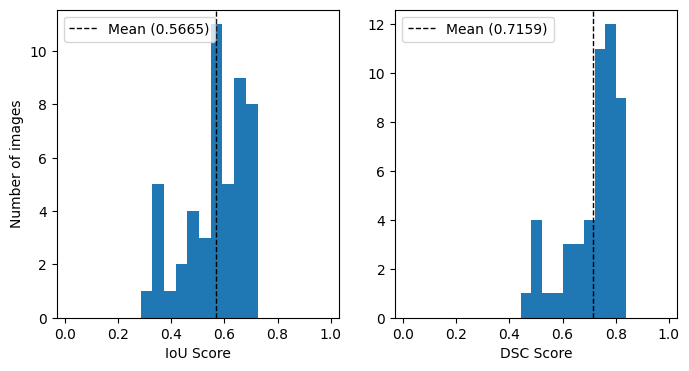

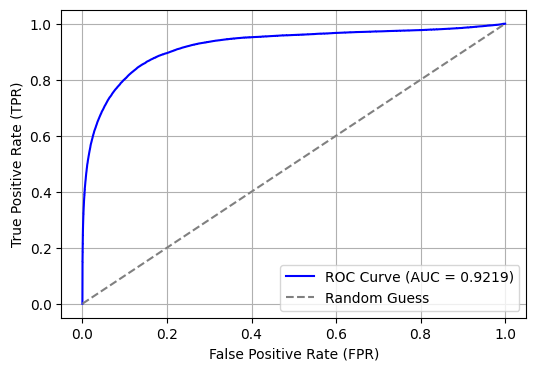

In [27]:
## Insert path to preprocessed test data, ending with /
test_data_path = r"C:\DATA\_KurserUNI\Deep Learning\Final Project\brightfield\test_data_64/"

unseen_images = DataLoader(dataset=CellDataset(test_data_path),
                           batch_size=BATCH_SIZE,
                           shuffle=True)

X_test, y_test = get_some_images(unseen_images, device, 49)

iou_extremes, dsc_extremes = visualize(model, X_test, y_test, m="Mean", debug=True)
